In [13]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = K.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

def load_images_and_masks(data_dir):
    images = []
    masks = []
    
    for patient_folder in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, patient_folder)):
            continue
        patient_path = os.path.join(data_dir, patient_folder)
        
        for file in os.listdir(patient_path):
            if file.endswith('.bmp'):
                # Load image
               
                image_path = os.path.join(patient_path, file)
                image = cv2.imread(image_path)
                images.append(image)
                
                # Create corresponding mask
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
                csv_file = file.replace('.bmp', '.csv')
                csv_path = os.path.join(patient_path, csv_file)
                
                if os.path.exists(csv_path):
                    try:
                        with open(csv_path, 'r') as f:
                            lines = f.readlines()
                            for line in lines:
                                values = line.strip().split(',')
                                # Ensure even number of values (pairs of coordinates)
                                if len(values) % 2 != 0:
                                    print(f"Warning: Skipping invalid row in {csv_path}: {line}")
                                    continue
                                # Convert pairs of coordinates to integers and set mask
                                for i in range(0, len(values), 2):
                                    try:
                                        col_idx = int(values[i])
                                        row_idx = int(values[i+1])
                                        mask[row_idx, col_idx] = 1
                                    except ValueError:
                                        print(f"Warning: Skipping invalid coordinate pair in {csv_path}: ({values[i]}, {values[i+1]})")
                    
                    except Exception as e:
                        print(f"Error reading {csv_path}: {e}")
                
                masks.append(mask)
    
    return np.array(images), np.array(masks)

def extract_patches(image, patch_size=64, stride=32):
    patches = []
    coordinates = []
    h, w = image.shape[:2]
    
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
            coordinates.append((y, x))
    return np.array(patches), coordinates



def reconstruct_mask(pred_patches, coordinates, image_shape, patch_size=64, stride=32):
    mask = np.zeros((image_shape[0], image_shape[1]))
    count = np.zeros((image_shape[0], image_shape[1]))

    for i, (y, x) in enumerate(coordinates):
        mask[y:y + patch_size, x:x + patch_size] += pred_patches[i].squeeze()
        count[y:y + patch_size, x:x + patch_size] += 1
    
    mask = np.divide(mask, count, out=np.zeros_like(mask), where=count!=0)
    return mask


def create_augmented_generators(images, masks, batch_size=32):
    data_gen_args = dict(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2]
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)
    
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)
    
    return image_generator, mask_generator


def oversample_mitosis_patches_generator(images, masks, patch_size=32, stride=16, oversample_factor=10):
    while True:
        for image, mask in zip(images, masks):
            coords = np.argwhere(mask == 1)
            for _ in range(oversample_factor):
                for y, x in coords:
                    y_min, y_max = max(0, y-patch_size//2), min(image.shape[0], y+patch_size//2)
                    x_min, x_max = max(0, x-patch_size//2), min(image.shape[1], x+patch_size//2)
                    patch = image[y_min:y_max, x_min:x_max]
                    patch_mask = mask[y_min:y_max, x_min:x_max]
                    
                    if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                        yield patch, patch_mask


def patch_generator(images, masks, patch_size=64, stride=16, batch_size=64):
    while True:
        batch_images = []
        batch_masks = []
        for image, mask in zip(images, masks):
            for y in range(0, image.shape[0] - patch_size + 1, stride):
                for x in range(0, image.shape[1] - patch_size + 1, stride):
                    image_patch = image[y:y + patch_size, x:x + patch_size]
                    mask_patch = mask[y:y + patch_size, x:x + patch_size]
                    batch_images.append(image_patch)
                    batch_masks.append(mask_patch)
                    if len(batch_images) == batch_size:
                        yield np.array(batch_images), np.expand_dims(np.array(batch_masks), axis=-1)
                        batch_images, batch_masks = [], []
        if batch_images:
            yield np.array(batch_images), np.expand_dims(np.array(batch_masks), axis=-1)

def balanced_patch_generator(images, masks, patch_size=32, stride=16, batch_size=32, oversample_factor=10):
    mitosis_generator = oversample_mitosis_patches_generator(images, masks, patch_size, stride, oversample_factor)
    
    while True:
        batch_images = []
        batch_masks = []
        
        non_mitosis_patches = []
        non_mitosis_coords = []
        
        for image, mask in zip(images, masks):
            coords = np.argwhere(mask == 0)
            for y, x in coords[::stride]:
                y_min, y_max = max(0, y-patch_size//2), min(image.shape[0], y+patch_size//2)
                x_min, x_max = max(0, x-patch_size//2), min(image.shape[1], x+patch_size//2)
                patch = image[y_min:y_max, x_min:x_max]
                patch_mask = mask[y_min:y_max, x_min:x_max]
                
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    non_mitosis_patches.append(patch)
                    non_mitosis_coords.append(patch_mask)
        
        while len(batch_images) < batch_size:
            try:
                if len(non_mitosis_patches) > 0:
                    mitosis_patch, mitosis_mask = next(mitosis_generator)
                    batch_images.append(mitosis_patch)
                    batch_masks.append(mitosis_mask)
                    batch_images.append(non_mitosis_patches.pop())
                    batch_masks.append(non_mitosis_coords.pop())
                else:
                    break
            except StopIteration:
                break
        
        if len(batch_images) > 0:
            batch_images = np.array(batch_images)
            batch_masks = np.expand_dims(np.array(batch_masks), axis=-1)

            # Apply augmentations
            image_generator, mask_generator = create_augmented_generators(batch_images, batch_masks, batch_size=batch_size)
            augmented_images = next(image_generator)
            augmented_masks = next(mask_generator)
            
            yield augmented_images, augmented_masks


def generator_to_dataset(generator, output_shape, batch_size):
    def gen():
        for batch in generator:
            yield batch
            
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(batch_size, *output_shape), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size, *output_shape, 1), dtype=tf.float32)
        )
    )
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def cross_validation(images, masks, n_splits=5, patch_size=32, stride=16, batch_size=32, oversample_factor=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for train_index, val_index in kf.split(images):
        X_train, X_val = images[train_index], images[val_index]
        y_train, y_val = masks[train_index], masks[val_index]

        train_generator = balanced_patch_generator(X_train, y_train, patch_size, stride, batch_size, oversample_factor)
        val_generator = balanced_patch_generator(X_val, y_val, patch_size, stride, batch_size, oversample_factor)
        
        num_train_patches = sum(
            (image.shape[0] - patch_size + 1) * (image.shape[1] - patch_size + 1) // (stride * stride)
            for image in X_train
        )
        num_val_patches = sum(
            (image.shape[0] - patch_size + 1) * (image.shape[1] - patch_size + 1) // (stride * stride)
            for image in X_val
        )

        fold_results.append((train_generator, val_generator, num_train_patches // batch_size, num_val_patches // batch_size, X_val, y_val))
    
    return fold_results

def unet_model(input_size=(64, 64, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Concatenate()([up6, conv4])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Concatenate()([up7, conv3])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Concatenate()([up8, conv2])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Concatenate()([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy', 'Precision', 'Recall'])
    
    return model

def calculate_metrics(y_true, y_pred):
    # Flatten the arrays to calculate the metrics at the pixel level
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Check for shape consistency
    if len(y_true) != len(y_pred):
        raise ValueError(f"Inconsistent number of samples: {len(y_true)} != {len(y_pred)}")
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    return precision, recall, f1

In [14]:
data_dir = 'scanner_A'  # Your data directory
input_size = (64, 64, 3)  # Define the input size for the model

# Load images and masks
images, masks = load_images_and_masks(data_dir)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 35 images and 35 masks.


In [18]:
tf.config.set_visible_devices([], 'GPU')
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
# Check class distribution
total_pixels = np.prod(masks.shape)
num_mitosis_pixels = np.sum(masks)
num_non_mitosis_pixels = total_pixels - num_mitosis_pixels
print(f"Mitosis pixels: {num_mitosis_pixels}, Non-mitosis pixels: {num_non_mitosis_pixels}")

# Perform 5-fold cross-validation
fold_results = cross_validation(images[:2], masks , n_splits=2,patch_size=64, stride=32, batch_size=256,oversample_factor=10)

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Mitosis pixels: 135376, Non-mitosis pixels: 151871584.0


In [19]:
for fold_num, (train_gen, val_gen, train_steps, val_steps, X_val, y_val) in enumerate(fold_results):
    print(f"Fold {fold_num + 1}")

    # Define and compile the model
    model = unet_model(input_size=input_size)
    # Train the model using the training generator and validate it on the validation data
    model.fit(train_gen,
                validation_data=val_gen,
                epochs=1,  # Adjust the number of epochs as needed
                steps_per_epoch=train_steps,
                validation_steps=val_steps, 
                verbose=1)
    
    print(f"Model trained on fold {fold_num + 1}")
    model.save('model.keras')

    # Reconstruct the full validation mask
    patches, coords = extract_patches(X_val[0], patch_size=64, stride=32)
    val_patch_preds = model.predict(patches)
    val_patch_preds = np.nan_to_num(val_patch_preds, nan=0.0, posinf=1.0, neginf=0.0)
    val_patch_preds = (val_patch_preds > 0.5).astype(np.uint8)  # Convert predictions to binary masks
    val_mask_pred = reconstruct_mask(val_patch_preds, coords, X_val[0].shape, patch_size=64, stride=32)
    
    precision, recall, f1 = calculate_metrics(y_val.flatten(), val_mask_pred.flatten())
    print(f"Fold {fold_num + 1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 127s 8s/step - Precision: 0.0328 - Recall: 0.2866 - accuracy: 0.7157 - loss: 2.7568 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9743 - val_loss: 0.0110
Model trained on fold 1
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step


/Users/samet.kucukbayraktar/Desktop/dev/mitosisDetection/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Fold 2
 2/15 ━━━━━━━━━━━━━━━━━━━━ 1:22 6s/step - Precision: 0.0357 - Recall: 0.0732 - accuracy: 0.9224 - loss: 0.2361

KeyboardInterrupt: 

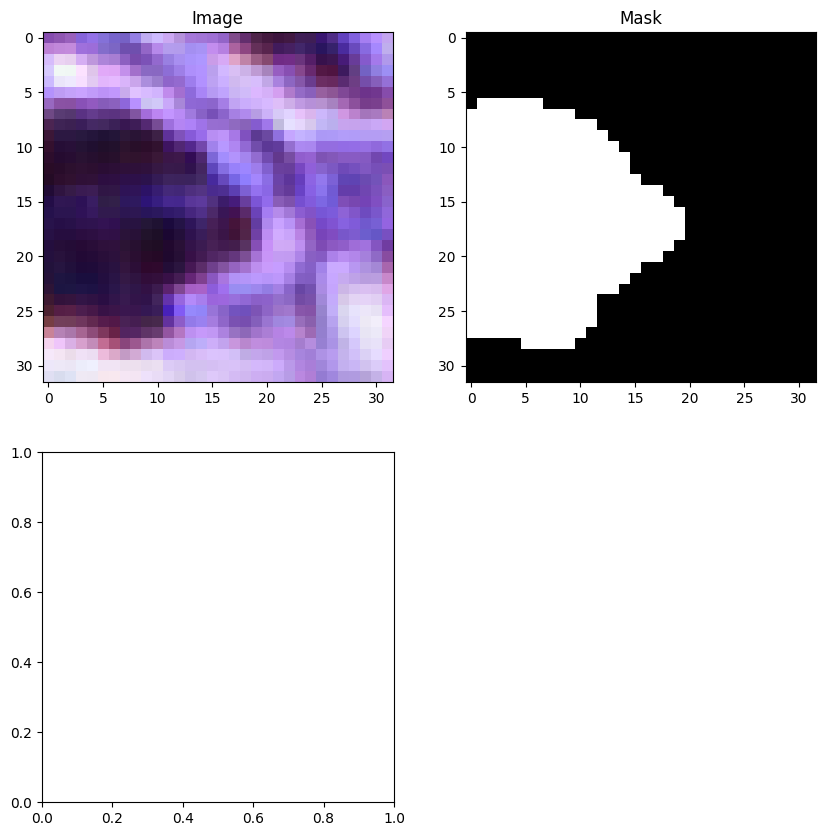

In [45]:
#model = tf.keras.models.load_model('model.keras', custom_objects={'focal_loss_fixed': focal_loss()})
for fold_num, (train_gen, val_gen, train_steps, val_steps, X_val, y_val) in enumerate(fold_results):
    next(train_gen)
    next(train_gen)
    image, mask = next(train_gen)
    plt.figure(figsize=(10, 10))
    plt.subplot(221)
    plt.imshow(image[0])
    plt.title('Image')
    plt.subplot(222)
    plt.imshow(mask[0].squeeze(), cmap='gray')
    plt.title('Mask')
    break



In [12]:
model = tf.keras.models.load_model('model.keras', custom_objects={'focal_loss_fixed': focal_loss()})
image = images[0]
mask = masks[0].squeeze()
patch_size = 64
stride = 32
patches, coords = extract_patches(image, patch_size=patch_size, stride=stride)
patch_preds = model.predict(patches)
patch_preds = np.nan_to_num(patch_preds, nan=0.0, posinf=1.0, neginf=0.0)
patch_preds = (patch_preds > 0.5).astype(np.uint8)
mask_pred = reconstruct_mask(patch_preds, coords, image.shape, patch_size=patch_size, stride=stride)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(image)
plt.title('Image')
plt.subplot(222)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.subplot(223)
plt.imshow(mask_pred, cmap='gray')
plt.title('Predicted Mask')

128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step


KeyboardInterrupt: 

In [ ]:
print("Training and evaluation completed.")
model.save('model.h5')